## Model Loading

This cell automatically detects the model type and loads the appropriate data source:

- **CLIP models** (text/vision): Uses pre-computed embeddings from `embeddings.safetensors`
- **FLUX models** (transformer_blocks): Samples activations on-the-fly from FLUX pipeline

The model name determines the activation source:
- `cc3m-text-*` → CLIP text pooled activations
- `cc3m-vision-*` → CLIP vision activations  
- `cc3m-single_transformer_blocks.*` → FLUX single transformer block activations
- `cc3m-transformer_blocks.*-*` → FLUX transformer block activations (with stream 0 or 1)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPVisionModel, CLIPTextModel
from diffusers import FluxPipeline
from einops import rearrange
from pathlib import Path
import polars as pl
from torch.utils.data import Dataset, DataLoader

import torchvision
from accelerate import Accelerator
from autoencoder import SparseAutoencoder, TopkSparseAutoencoder
from datalib import SafeTensorDataset
from fluxsae import FluxActivationSampler, CC3MPromptDataset

# Use mixed precision for efficiency (bf16 is faster and uses less memory)
# NOTE: This requires converting inputs to bfloat16 to avoid type mismatch errors
accelerator = Accelerator(mixed_precision="bf16")
USE_MIXED_PRECISION = True  # Flag to indicate mixed precision is enabled

# choose the SAE to load
# name = "cc3m-text-topk-lr-3e-4-k-4-expansion-4"
name = "cc3m-single_transformer_blocks.9"
model = TopkSparseAutoencoder.from_pretrained(f"RE-N-Y/{name}")

# Detect model type based on name
is_flux_model = "transformer_blocks" in name or "single_transformer_blocks" in name
is_clip_text_model = "text" in name and not is_flux_model
is_clip_vision_model = "vision" in name and not is_flux_model

print(f"Model: {name}")
print(f"Model type: {'FLUX' if is_flux_model else 'CLIP ' + ('text' if is_clip_text_model else 'vision')}")

if is_flux_model:
    # For FLUX models, we need to sample activations on-the-fly
    # Extract location from model name
    # Examples:
    #   "cc3m-single_transformer_blocks.9" -> "single_transformer_blocks.9"
    #   "cc3m-transformer_blocks.18-0" -> "transformer_blocks.18"
    #   "cc3m-transformer_blocks.18-1" -> "transformer_blocks.18"
    
    if "single_transformer_blocks" in name:
        # Extract "single_transformer_blocks.9" from "cc3m-single_transformer_blocks.9"
        loc = name.split("cc3m-")[-1]  # Remove "cc3m-" prefix
    elif "transformer_blocks" in name:
        # Format: cc3m-transformer_blocks.18-0 -> transformer_blocks.18
        # Remove "cc3m-" prefix and strip stream suffix (-0 or -1)
        loc_with_stream = name.split("cc3m-")[-1]
        # Remove stream suffix if present (format: transformer_blocks.18-0)
        if "-" in loc_with_stream:
            loc = loc_with_stream.rsplit("-", 1)[0]  # Remove last part after "-"
        else:
            loc = loc_with_stream
    else:
        raise ValueError(f"Could not determine location from model name: {name}")
    
    print(f"FLUX activation location: {loc}")
    
    # For transformer_blocks, also extract stream if specified
    stream = 0  # default
    if "transformer_blocks" in name and "-" in name.split("cc3m-")[-1]:
        stream_part = name.split("cc3m-")[-1].split("-")[-1]
        if stream_part.isdigit():
            stream = int(stream_part)
    
    # Load FLUX pipeline and activation sampler
    sampler = FluxActivationSampler("black-forest-labs/FLUX.1-schnell", loc=loc)
    dataset = CC3MPromptDataset(folder="/mnt/drive_a/Projects/sae/data/cc3m/")
    
    # Prepare models
    sampler.pipe.transformer, sampler.pipe.vae, sampler.pipe.text_encoder, sampler.pipe.text_encoder_2 = accelerator.prepare(
        sampler.pipe.transformer, sampler.pipe.vae, sampler.pipe.text_encoder, sampler.pipe.text_encoder_2
    )
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, drop_last=True)  # Smaller batch for FLUX
    dataloader = accelerator.prepare(dataloader)
    
    # Store sampler and stream for use in next cell
    activation_sampler = sampler
    activation_sampler.stream = stream  # Store stream info for transformer_blocks
    use_flux = True
    
elif is_clip_text_model or is_clip_vision_model:
    # For CLIP models, use pre-computed embeddings
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
    vit = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14", attn_implementation="sdpa")
    text = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", attn_implementation="sdpa")
    
    # Determine which embeddings to load
    embedding_key = "text" if is_clip_text_model else "vision"
    dataset = SafeTensorDataset("/mnt/drive_a/Projects/sae/data/cc3m/embeddings.safetensors", embedding_key)
    
    vit, text = torch.compile(vit), torch.compile(text)
    dataloader = dataset.dataloader(batch_size=1024, num_workers=96, drop_last=True)
    dataloader = accelerator.prepare(dataloader)
    
    activation_sampler = None
    use_flux = False
    
else:
    raise ValueError(f"Unknown model type: {name}")

model = accelerator.prepare(model)
print(f"Model prepared. Features: {model.features}, Pages: {model.pages}")


Model: cc3m-single_transformer_blocks.9
Model type: FLUX
FLUX activation location: single_transformer_blocks.9


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model prepared. Features: 3072, Pages: 49152


In [24]:
from tqdm import tqdm

# track topk inputs with highest activation for k-th hidden unit
topk = 16
pages = model.pages

# Use float32 for computation, then convert to bfloat16 at the end
topk_values = torch.zeros(pages, topk, dtype=torch.float32, device="cpu")
topk_idxes = torch.full((pages, topk), -1, dtype=torch.int64, device="cpu")
topk_count = torch.zeros(pages, dtype=torch.int64, device="cpu")  # Track how many valid entries we have

print(f"Processing activations...")
print(f"Using {'FLUX activation sampler' if use_flux else 'pre-computed CLIP embeddings'}")

# Get model dtype and device for consistency checks
model_param = next(model.parameters())
model_dtype = model_param.dtype
model_device = model_param.device

# IMPORTANT: With mixed_precision="bf16" enabled, we MUST convert inputs to bfloat16
# Even though model parameters are float32, autocast converts operations to bfloat16 during forward pass
# If input is float32 and bias gets autocast to bfloat16, we get the error:
# "RuntimeError: Input type (float) and bias type (c10::BFloat16) should be the same"
# Solution: Convert inputs to bfloat16 BEFORE passing to model.encode()
if USE_MIXED_PRECISION:
    target_dtype = torch.bfloat16
else:
    target_dtype = model_dtype

print(f"Model dtype: {model_dtype}, device: {model_device}")
print(f"Mixed precision enabled: {USE_MIXED_PRECISION}")
print(f"Target input dtype: {target_dtype}")

# Track global index offset
global_idx_offset = 0

# online topk algorithm - properly merge top-k lists
for bidx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    # Get activations based on model type
    if use_flux:
        # For FLUX: sample activations on-the-fly
        with activation_sampler as s:
            outputs = s(batch, height=256, width=256, guidance_scale=0., max_sequence_length=256, num_inference_steps=1)
            activations = outputs["activations"]
        
        # Handle different FLUX activation formats
        if "single_transformer_blocks" in activation_sampler.loc:
            # single_transformer_blocks returns activations directly
            x = activations
        elif "transformer_blocks" in activation_sampler.loc:
            # transformer_blocks returns a tuple (stream0, stream1)
            # Use the stream specified when loading the model
            stream = getattr(activation_sampler, 'stream', 0)
            if isinstance(activations, tuple) and len(activations) == 2:
                if stream == 0:
                    x, _ = activations
                else:
                    _, x = activations
            else:
                # Fallback: assume it's already the correct stream
                x = activations
        else:
            x = activations
        
        # Reshape: FLUX activations may have shape (batch, seq_len, dim) or (batch, dim)
        # We want to flatten to (batch * seq_len, dim) or keep as (batch, dim)
        x = rearrange(x, "b ... d -> (b ...) d")
        # For FLUX, each batch item (prompt) may produce multiple activation vectors
        # We need to map them back to the original prompt index
        num_prompts = len(batch) if isinstance(batch, list) else batch.shape[0]
        activations_per_prompt = x.shape[0] // num_prompts if x.shape[0] % num_prompts == 0 else 1
        
    else:
        # For CLIP: use pre-computed embeddings directly
        x = batch  # batch is already the activations
        num_prompts = x.shape[0]
        activations_per_prompt = 1
    
    # Convert activations to match model device and appropriate dtype
    # With mixed precision bf16, convert to bfloat16 to avoid type mismatch during autocast
    # The autocast context will handle bfloat16 operations correctly
    if x.device != model_device:
        x = x.to(device=model_device)
    
    # Convert dtype: use bfloat16 if mixed precision is enabled, otherwise use model dtype
    # This is critical to avoid: "RuntimeError: Input type (float) and bias type (c10::BFloat16) should be the same"
    if x.dtype != target_dtype:
        x = x.to(dtype=target_dtype)
    
    # Debug: Print dtype info for first batch only
    if bidx == 0:
        print(f"  Batch {bidx}: Input dtype after conversion: {x.dtype}, shape: {x.shape}")
    
    # Encode with SAE (will use autocast if mixed precision is enabled)
    dictionary = model.encode(x)

    _topk_values, _topk_idxes = torch.topk(dictionary.T, k=topk, dim=-1, sorted=True)
    
    # Map activation indices back to dataset indices
    # For CLIP: 1 activation per sample, so idx maps directly
    # For FLUX: multiple activations per prompt, map to prompt index
    if use_flux and activations_per_prompt > 1:
        # Each activation vector corresponds to a position in the sequence
        # Map back to the prompt index: activation_idx // activations_per_prompt
        activation_indices = _topk_idxes.clone()
        prompt_indices = activation_indices // activations_per_prompt
        _topk_idxes = prompt_indices + global_idx_offset
    else:
        # Direct mapping: each activation = one dataset sample
        _topk_idxes = _topk_idxes + global_idx_offset
    
    # Update offset for next batch
    global_idx_offset += num_prompts

    _topk_idxes = _topk_idxes.detach().cpu()
    _topk_values = _topk_values.float().detach().cpu()

    # Properly merge top-k: concatenate and take top-k again for each page
    for page_idx in range(pages):
        # Get current valid entries for this page
        current_count = topk_count[page_idx].item()
        if current_count > 0:
            # We have existing entries, merge them
            current_values = topk_values[page_idx, :current_count]
            current_idxes = topk_idxes[page_idx, :current_count]
            # Concatenate with new top-k
            combined_values = torch.cat([current_values, _topk_values[page_idx]])
            combined_idxes = torch.cat([current_idxes, _topk_idxes[page_idx]])
        else:
            # First batch for this page
            combined_values = _topk_values[page_idx]
            combined_idxes = _topk_idxes[page_idx]
        
        # Take top-k from combined
        sorted_indices = torch.argsort(combined_values, descending=True)[:topk]
        actual_k = min(len(sorted_indices), topk)
        topk_values[page_idx, :actual_k] = combined_values[sorted_indices[:actual_k]]
        topk_idxes[page_idx, :actual_k] = combined_idxes[sorted_indices[:actual_k]]
        topk_count[page_idx] = actual_k

# Convert to bfloat16 for consistency with original code
topk_values = topk_values.to(torch.bfloat16)

# Mark invalid entries (where we don't have topk entries yet) with -1 indices
for page_idx in range(pages):
    count = topk_count[page_idx].item()
    if count < topk:
        topk_idxes[page_idx, count:] = -1

# now you can use topk_idxes to get topk inputs, images, texts, from the dataset...
print(f"Computed top-{topk} activations for {pages} features")
print(f"Average valid entries per feature: {topk_count.float().mean():.1f}/{topk}")

Processing activations...
Using FLUX activation sampler
Model dtype: torch.float32, device: cuda:0
Mixed precision enabled: True
Target input dtype: torch.bfloat16


  0%|          | 0/89298 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (124 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['tree trunks. the image is taken from a low angle, emphasizing the height of the trees and the vastness of the sky. the overall composition of the image suggests a peaceful, natural setting, possibly a forest or a park. <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/89298 [00:01<?, ?it/s]


RuntimeError: Input type (float) and bias type (c10::BFloat16) should be the same

In [7]:
import io
import json
from pathlib import Path
from PIL import Image
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load CC3M dataset class
class CC3MImageLoader:
    def __init__(self, folder: Path | str = None):
        if folder is None:
            folder = Path("/mnt/drive_a/Projects/sae/data/cc3m/")
        self.folder = Path(folder)
        
        # Try to load from JSON first (faster if images are already written to disk)
        captions_path = self.folder / "captions.json"
        image_paths_path = self.folder / "image_paths.json"
        
        if captions_path.exists() and image_paths_path.exists():
            print("Loading captions and image paths from JSON...")
            with open(captions_path, 'r') as f:
                self.captions = json.load(f)
            with open(image_paths_path, 'r') as f:
                self.image_paths = json.load(f)
            self.use_json = True
            print(f"Loaded {len(self.captions)} captions and {len(self.image_paths)} image paths")
        else:
            # Load from parquet files
            print("Loading dataset from parquet files...")
            data = []
            for file in sorted(self.folder.glob("*.parquet")):
                data.append(pl.read_parquet(file))
            self.dataset = pl.concat(data)
            self.use_json = False
            print(f"Loaded {len(self.dataset)} samples from parquet files")
    
    def get_image_and_text(self, idx: int, debug: bool = False):
        """Get image and text for a given global index"""
        if self.use_json:
            # Load from disk using image_paths
            idx_str = str(idx)
            if idx_str not in self.image_paths:
                if debug:
                    print(f"  Index {idx} not found in image_paths (max key: {max(int(k) for k in self.image_paths.keys()) if self.image_paths else 'N/A'})")
                return None, None
            
            # The image_paths in JSON are relative to the cc3m folder, not the parent
            # JSON has paths like "images/train-00000-of-00281/0.jpg"
            # Actual location: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00000-of-00281/0.jpg
            image_path = self.folder / self.image_paths[idx_str]
            if debug:
                print(f"  Looking for image at: {image_path}")
                print(f"  Path exists: {image_path.exists()}")
            
            if not image_path.exists():
                if debug:
                    print(f"  Image file does not exist: {image_path}")
                return None, None
            
            try:
                image = Image.open(image_path).convert('RGB')
                caption = self.captions.get(idx_str, "No caption")
                return image, caption
            except Exception as e:
                if debug:
                    print(f"  Error opening image: {e}")
                return None, None
        else:
            # Load from parquet
            try:
                if idx >= len(self.dataset):
                    if debug:
                        print(f"  Index {idx} out of range (dataset size: {len(self.dataset)})")
                    return None, None
                row = self.dataset.row(idx, named=True)
                image = Image.open(io.BytesIO(row['image']['bytes'])).convert('RGB')
                text = row["conversations"][-1]['value']
                return image, text
            except Exception as e:
                if debug:
                    print(f"Error loading index {idx}: {e}")
                return None, None

# Initialize image loader
image_loader = CC3MImageLoader()


Loading captions and image paths from JSON...
Loaded 2857560 captions and 2857560 image paths


In [8]:
# Debug: Test loading a few known indices
print("Testing image loading with debug enabled...")
print(f"Image loader folder: {image_loader.folder}")
print(f"Image loader folder parent: {image_loader.folder.parent}")
print(f"Using JSON: {image_loader.use_json}")

# Test with a small index that should exist
test_indices = [0, 1, 100, 1000]
for test_idx in test_indices:
    print(f"\nTesting index {test_idx}:")
    img, caption = image_loader.get_image_and_text(test_idx, debug=True)
    if img:
        print(f"  SUCCESS: Loaded image of size {img.size}")
    else:
        print(f"  FAILED: Could not load image")


Testing image loading with debug enabled...
Image loader folder: /mnt/drive_a/Projects/sae/data/cc3m
Image loader folder parent: /mnt/drive_a/Projects/sae/data
Using JSON: True

Testing index 0:
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00000-of-00281/0.jpg
  Path exists: True
  SUCCESS: Loaded image of size (614, 512)

Testing index 1:
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00000-of-00281/1.jpg
  Path exists: True
  SUCCESS: Loaded image of size (646, 512)

Testing index 100:
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00000-of-00281/100.jpg
  Path exists: True
  SUCCESS: Loaded image of size (640, 447)

Testing index 1000:
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00000-of-00281/1000.jpg
  Path exists: True
  SUCCESS: Loaded image of size (696, 512)


Visualizing feature 0...
Attempting to load index 610715 (value: 16.6250)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00060-of-00281/515.jpg
  Path exists: True
Attempting to load index 1523194 (value: 16.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00149-of-00281/7942.jpg
  Path exists: True
Attempting to load index 333336 (value: 16.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00032-of-00281/7896.jpg
  Path exists: True


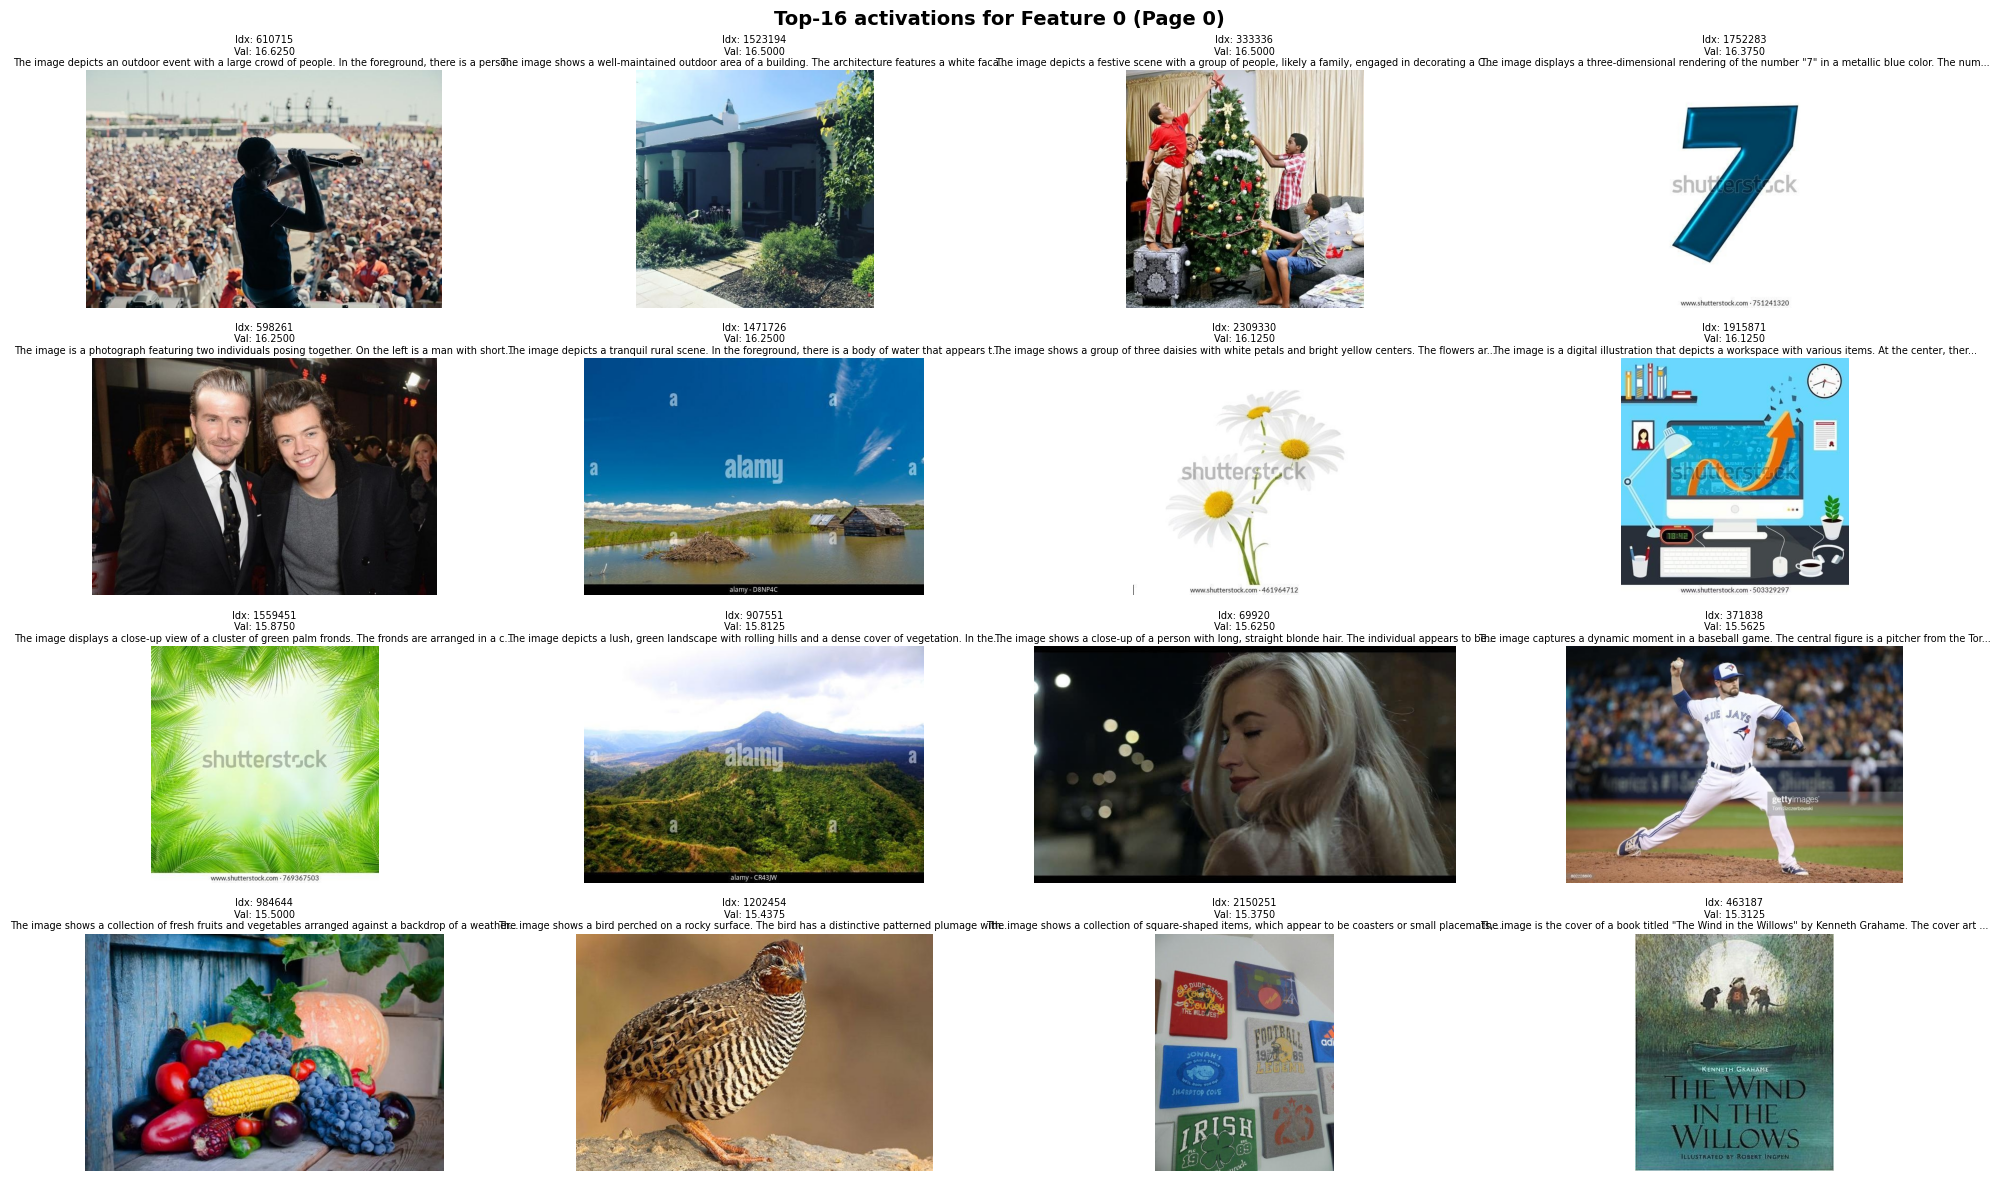

([<PIL.Image.Image image mode=RGB size=745x497>,
  <PIL.Image.Image image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=450x470>,
  <PIL.Image.Image image mode=RGB size=742x512>,
  <PIL.Image.Image image mode=RGB size=640x447>,
  <PIL.Image.Image image mode=RGB size=439x470>,
  <PIL.Image.Image image mode=RGB size=450x470>,
  <PIL.Image.Image image mode=RGB size=450x470>,
  <PIL.Image.Image image mode=RGB size=640x447>,
  <PIL.Image.Image image mode=RGB size=852x480>,
  <PIL.Image.Image image mode=RGB size=726x512>,
  <PIL.Image.Image image mode=RGB size=612x405>,
  <PIL.Image.Image image mode=RGB size=750x500>,
  <PIL.Image.Image image mode=RGB size=480x640>,
  <PIL.Image.Image image mode=RGB size=402x480>],
 ['Idx: 610715\nVal: 16.6250\nThe image depicts an outdoor event with a large crowd of people. In the foreground, there is a perso...',
  'Idx: 1523194\nVal: 16.5000\nThe image shows a well-maintained outdoor area o

In [11]:
def visualize_topk_images_for_feature(feature_idx: int, topk_indices: torch.Tensor, topk_values: torch.Tensor, 
                                       image_loader: CC3MImageLoader, num_images: int = None, 
                                       figsize: tuple = (20, 12)):
    """
    Visualize top-k images for a specific feature (dictionary element).
    
    Args:
        feature_idx: Index of the feature/dictionary element to visualize
        topk_indices: Tensor of shape (pages, topk) containing global indices
        topk_values: Tensor of shape (pages, topk) containing activation values
        image_loader: CC3MImageLoader instance
        num_images: Number of images to show (default: all in topk)
        figsize: Figure size for matplotlib
    """
    if num_images is None:
        num_images = topk_indices.shape[1]
    else:
        num_images = min(num_images, topk_indices.shape[1])
    
    # Get indices and values for this feature
    # Convert to float32 first if needed (for bfloat16)
    values = topk_values[feature_idx, :num_images].float().cpu().numpy()
    indices = topk_indices[feature_idx, :num_images].cpu().numpy()
    
    # Filter out invalid indices (-1)
    valid_mask = indices >= 0
    indices = indices[valid_mask]
    values = values[valid_mask]
    
    if len(indices) == 0:
        print(f"No valid images found for feature {feature_idx}")
        return
    
    # Load images and captions
    images = []
    captions = []
    failed_indices = []
    for i, (idx, val) in enumerate(zip(indices, values)):
        # Debug first few attempts
        debug = (i < 3)
        if debug:
            print(f"Attempting to load index {int(idx)} (value: {val:.4f})...")
        img, caption = image_loader.get_image_and_text(int(idx), debug=debug)
        if img is not None:
            images.append(img)
            # Truncate caption if too long
            caption_display = caption[:100] + "..." if len(caption) > 100 else caption
            captions.append(f"Idx: {int(idx)}\nVal: {val:.4f}\n{caption_display}")
        else:
            failed_indices.append(int(idx))
    
    if len(images) == 0:
        print(f"No images could be loaded for feature {feature_idx}")
        print(f"Tried to load {len(indices)} indices, all failed")
        print(f"Sample failed indices: {failed_indices[:10]}")
        print(f"Index range: {int(indices.min())} to {int(indices.max())}")
        # Try to get max index from image_paths
        if hasattr(image_loader, 'image_paths') and image_loader.image_paths:
            max_key = max(int(k) for k in image_loader.image_paths.keys())
            print(f"Max index in image_paths: {max_key}")
        return
    
    # Create visualization
    cols = 4
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    axes = axes.flatten()
    
    for i, (img, caption) in enumerate(zip(images, captions)):
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(caption, fontsize=7, pad=3)
    
    # Hide unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f"Top-{len(images)} activations for Feature {feature_idx} (Page {feature_idx})", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return images, captions


# Example: Visualize top-k images for the first feature
print("Visualizing feature 0...")
visualize_topk_images_for_feature(0, topk_idxes, topk_values, image_loader, num_images=16)


Top 5 features by mean:
  1. Feature 2803: mean = 31.9688
  2. Feature 530: mean = 24.5000
  3. Feature 2508: mean = 23.6875
  4. Feature 2015: mean = 23.2109
  5. Feature 1650: mean = 23.1094

Visualizing top features...

Feature 2803
Attempting to load index 156917 (value: 32.7500)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00015-of-00281/4367.jpg
  Path exists: True
Attempting to load index 334116 (value: 32.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00032-of-00281/8676.jpg
  Path exists: True
Attempting to load index 1331677 (value: 32.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00130-of-00281/9636.jpg
  Path exists: True


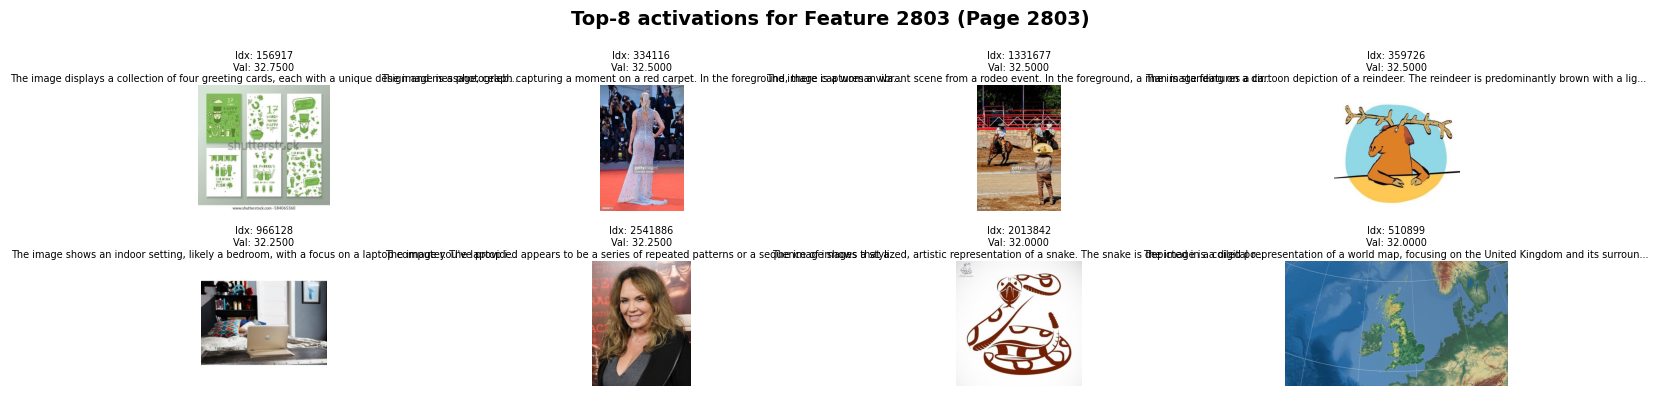


Feature 530
Attempting to load index 1922381 (value: 24.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00189-of-00281/369.jpg
  Path exists: True
Attempting to load index 2635379 (value: 24.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00259-of-00281/1537.jpg
  Path exists: True
Attempting to load index 2779174 (value: 24.5000)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00273-of-00281/2966.jpg
  Path exists: True


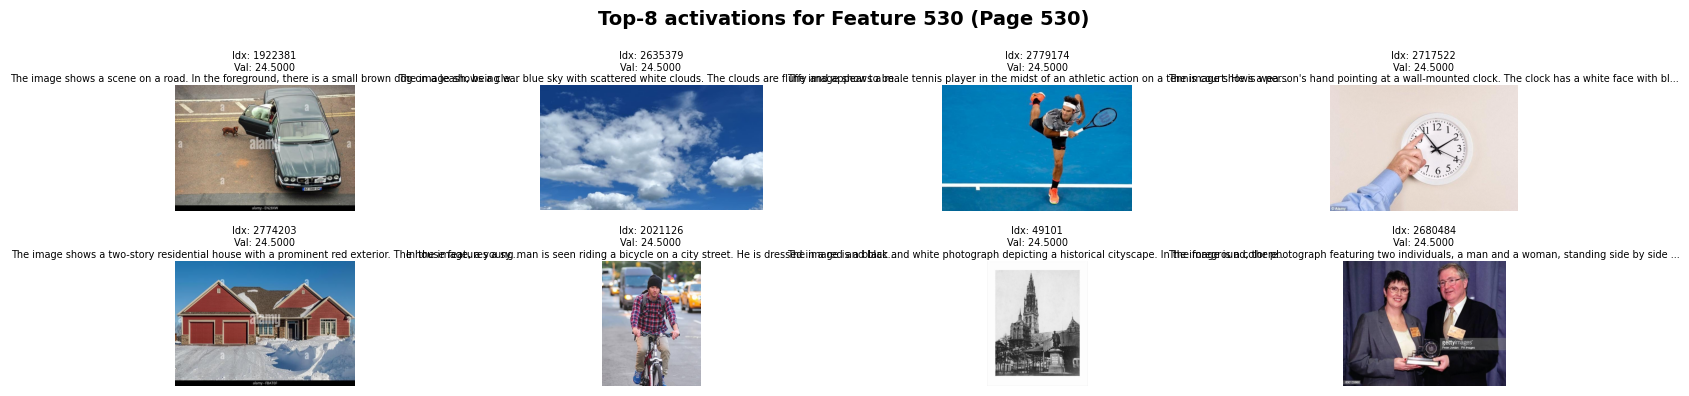


Feature 2508
Attempting to load index 1347798 (value: 23.8750)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00132-of-00281/5419.jpg
  Path exists: True
Attempting to load index 995215 (value: 23.8750)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00097-of-00281/8751.jpg
  Path exists: True
Attempting to load index 2201252 (value: 23.8750)...
  Looking for image at: /mnt/drive_a/Projects/sae/data/cc3m/images/train-00216-of-00281/4677.jpg
  Path exists: True


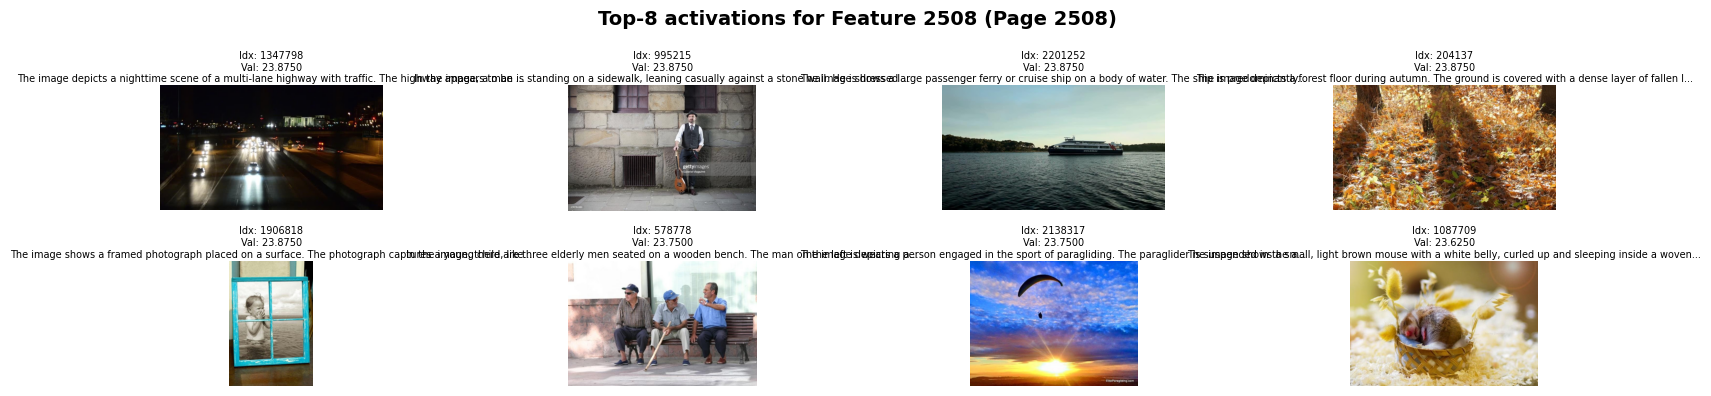

In [10]:
def visualize_multiple_features(feature_indices: list, topk_indices: torch.Tensor, topk_values: torch.Tensor,
                                  image_loader: CC3MImageLoader, num_images_per_feature: int = 8,
                                  figsize_per_feature: tuple = (16, 4)):
    """
    Visualize top-k images for multiple features.
    
    Args:
        feature_indices: List of feature indices to visualize
        topk_indices: Tensor of shape (pages, topk) containing global indices
        topk_values: Tensor of shape (pages, topk) containing activation values
        image_loader: CC3MImageLoader instance
        num_images_per_feature: Number of images to show per feature
        figsize_per_feature: Figure size for each feature's visualization
    """
    for feature_idx in feature_indices:
        print(f"\n{'='*80}")
        print(f"Feature {feature_idx}")
        print(f"{'='*80}")
        visualize_topk_images_for_feature(
            feature_idx, topk_indices, topk_values, image_loader, 
            num_images=num_images_per_feature, figsize=figsize_per_feature
        )


def find_interesting_features(topk_values: torch.Tensor, num_features: int = 10, 
                               criterion: str = "mean"):
    """
    Find interesting features based on different criteria.
    
    Args:
        topk_values: Tensor of shape (pages, topk) containing activation values
        num_features: Number of features to return
        criterion: "mean", "max", or "std" - how to rank features
    
    Returns:
        List of feature indices sorted by the criterion
    """
    if criterion == "mean":
        scores = topk_values.float().mean(dim=1)
    elif criterion == "max":
        scores = topk_values.float().max(dim=1)[0]
    elif criterion == "std":
        scores = topk_values.float().std(dim=1)
    else:
        raise ValueError(f"Unknown criterion: {criterion}")
    
    # Get top features
    top_indices = torch.argsort(scores, descending=True)[:num_features].cpu().tolist()
    
    print(f"Top {num_features} features by {criterion}:")
    for i, feat_idx in enumerate(top_indices):
        print(f"  {i+1}. Feature {feat_idx}: {criterion} = {scores[feat_idx]:.4f}")
    
    return top_indices


# Find interesting features
interesting_features = find_interesting_features(topk_values, num_features=5, criterion="mean")
print(f"\nVisualizing top features...")
visualize_multiple_features(interesting_features[:3], topk_idxes, topk_values, image_loader, 
                            num_images_per_feature=8)


## Summary

This notebook visualizes the top-k activations for a trained SAE model on CC3M text embeddings.

### What we've done:
1. **Fixed the top-k merging algorithm**: The original code used `torch.where` which doesn't properly merge sorted top-k lists. The new code correctly concatenates and re-sorts to get the true top-k across all batches.

2. **Created image visualization functions**:
   - `visualize_topk_images_for_feature()`: Visualizes top-k images for a single feature
   - `visualize_multiple_features()`: Visualizes multiple features in sequence
   - `find_interesting_features()`: Finds features with highest mean/max/std activations

3. **Image loading**: The code automatically tries to load images from disk (if `captions.json` and `image_paths.json` exist) or from parquet files.

### Usage examples:

```python
# Visualize a specific feature
visualize_topk_images_for_feature(0, topk_idxes, topk_values, image_loader, num_images=16)

# Find and visualize interesting features
interesting = find_interesting_features(topk_values, num_features=5, criterion="mean")
visualize_multiple_features(interesting[:3], topk_idxes, topk_values, image_loader)
```

### Notes:
- The `topk_idxes` tensor contains global indices into the CC3M dataset
- Invalid entries are marked with -1
- Images are loaded with their corresponding captions
- The visualization shows activation values and dataset indices for each image


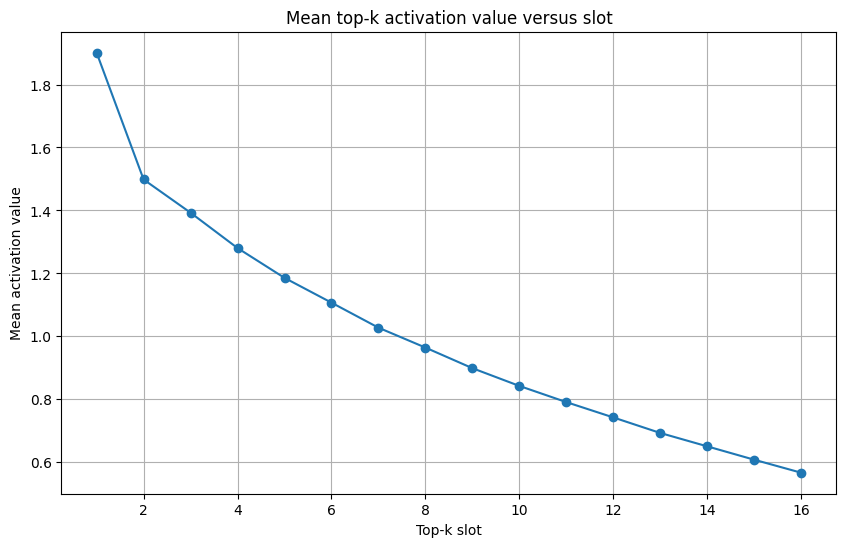

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
mean_topk_per_slot = topk_values.float().mean(dim=0)  # mean over pages, for each topk slot
plt.plot(range(1, topk + 1), mean_topk_per_slot, marker='o')
plt.xlabel("Top-k slot")
plt.ylabel("Mean activation value")
plt.title("Mean top-k activation value versus slot")
plt.grid(True)
plt.show()